# A Simple GAN with Keras

This notebook presents how to build a simple Generative Adversarial Network or GAN using the Keras API running on top of Tensorflow, based on [this tutorial from Datacamp](https://www.datacamp.com/community/tutorials/generative-adversarial-networks). The model will be trained under different parameters and conditions in order to better understand the way GANs work.

Generative Adversarial Networks (or GANs) are a type of generative model. Thus, their goal is to approximate the data distribution of given real data. In this case, the MNIST handwritten digits dataset will be used to train our GAN to generate images that are similar to the real images in MNIST.

A GAN is made of two neural networks that compete against each other. One network is the discriminator, whose task is to differentiate between real and generated data. The other network is the generator, whose task is to generate data that "tricks" the discriminator and passes as real.

## Import modules and set relevant parameters

As mentioned above, the GAN will be built and trained using Keras. Other useful packages are imported to visualize the images and training statistics as well as to interact with the OS to save the results.

In [68]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.models import model_from_json

import keras.backend as K


%matplotlib inline

In [30]:
# Use Tensorflow for Keras backend
os.environ["KERAS_BACKEND"] = "tensorflow"

# Make sure we can reproduce the experiment and get the same result
np.random.seed(10)

# The dimension of our random noise vector
random_dim = 100

## Gathering and preprocessing MNIST data

Keras includes MNIST as an example dataset. The 28x28 images are unrolled into vectors of 784 elements, which are normalized as seen below.

In [31]:
def load_mnist_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    # remember that the value of each attribute (pixel) ranges from 0 to 255
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    # same with x_test
    x_test = (x_test.astype(np.float32) - 127.5)/127.5
    x_test = x_test.reshape(x_test.shape[0], 784)
    return (x_train, y_train, x_test, y_test)

## Defining our optimizer
We will use the stochastic gradient-based optimizer Adam

In [32]:
# Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

## Defining our generator and discriminator

Both discriminator and generator will be represented by a Neural Network with three hidden layers. The generator will have fully connected layers whereas the discriminator will use layers with a dropout rate of 0.3.

The generator uses ReLU activation functions in all units except in the output layer, where the hyperbolic tangent function is used. The hyperbolic tangent function will ouput a value between -1 and 1, which is consistent with how the image data have been normalized.

The discriminator also uses ReLU activations for all of its layers except for its output unit where the sigmoid function is used, given that the discriminator's output is a probability.

In [33]:
# generator
def get_generator(optimizer):
    generator = Sequential()
    
    # first hidden layer
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    # second hidden layer
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    # third hidden layer
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    # the output layer (784 units) has a different activation function
    generator.add(Dense(784, activation='tanh'))
    
    # a Keras model needs two arguments to compile: loss function and optimizer
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

# discriminator
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

## Defining the GAN

Finally, the GAN is defined by taking as input a random noise vector that goes into the generator. The generator's output is then fed into the discriminator which outputs a single value (the probability of the generated image being real).

In [34]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

The following function will help visualize some images generated by the GAN in each epoch.

In [71]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=25, dim=(5, 5), figsize=(5, 5)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    fig = plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    display(fig)
    plt.savefig(os.path.join("img", "gan_generated_image_epoch_{0}.png".format(epoch)))
    plt.close()

Functions to save and load models from json and h5 files are also defined.

In [60]:
# Save model
def save_model(directory, discriminator, generator, gan):
    os.mkdir(directory)
    
    generator_json = generator.to_json()
    with open(os.path.join(directory, "generator.json"), "w") as json_file:
        json_file.write(generator_json)

    discriminator_json = discriminator.to_json()
    with open(os.path.join(directory, "discriminator.json"), "w") as json_file:
        json_file.write(discriminator_json)

    gan_json = gan.to_json()
    with open(os.path.join(directory, "gan.json"), "w") as json_file:
        json_file.write(gan_json)

    # save weights
    generator.save_weights(os.path.join(directory, "generator.h5"))
    discriminator.save_weights(os.path.join(directory, "discriminator.h5"))
    gan.save_weights(os.path.join(directory,"gan.h5"))

    print("Saved model to disk")

# Load model and weights
def load_model(directory):
    with open(os.path.join(directory, "generator.json"), "r") as json_file:
        loaded_gen_json = json_file.read()
        json_file.close()
        generator = model_from_json(loaded_gen_json)
    
    generator.load_weights(os.path.join(directory, "generator.h5"))
    print("Loaded generator model from disk")

    with open(os.path.join(directory, "discriminator.json"), "r") as json_file:
        loaded_disc_json = json_file.read()
        json_file.close()
        discriminator = model_from_json(loaded_disc_json)

    discriminator.load_weights(os.path.join(directory, "discriminator.h5"))
    print("Loaded discriminator model from disk")
    
    with open(os.path.join(directory, "gan.json"), "r") as json_file:
        loaded_gan_json = json_file.read()
        json_file.close()
        gan = model_from_json(loaded_gan_json)
    
    gan.load_weights(os.path.join(directory, "gan.h5"))
    print("Loaded gan model from disk")
    
    return discriminator, generator, gan

## Training function

There are two separate networks being trained: the discriminator and the generator.

It would be extremeley costly to have an optimal discriminator every time the generator is trained. Instead, weight updates of discriminator and generator are alternated in every training iteration.

First, the discriminator is trained on a batch composed of real training examples and images generated by the generator.

Then, the generator is trained by feeding a batch of generated images to the discriminator and updating the weights of the generator in order to minimize its cost function, that is in order to generate images closer to the real distribution.

Finally, it is possible to do more than one weight update to the discriminator to keep it closer to its optimal point as it will be discussed later.

Every 20 epochs a set of images is generated to visualize the improvement of the model. Besides, the discriminator is evaluated on a batch made of generated images and MNIST test data in order to see its performance.

In [37]:
def train(epochs=1, batch_size=128, k=1):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_mnist_data()
    # Number of batches (iterations) per epoch
    batch_count = x_train.shape[0] // batch_size
    
    # Build our GAN network
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
    
    # Initialize empty lists for model metrics
    discriminator_train_history, gan_history = [], []
    discriminator_test_history = []   
    print("Training...\n")
    
    for e in range(1, epochs+1):
        for _ in range(batch_count):
            for _ in range(k):
                # Training discriminator
                # Get a random batch of input noise and images
                noise = np.random.normal(0, 1, size=[batch_size, random_dim])
                image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

                # Generate fake MNIST images
                generated_images = generator.predict(noise)
                X = np.concatenate([image_batch, generated_images])

                # Labels for generated and real data
                # First half of the images are real, second half are fake
                y_dis = np.zeros(2*batch_size)
                # One-sided label smoothing
                y_dis[:batch_size] = 0.9

                # Train discriminator on batch
                discriminator.trainable = True
                discriminator_metrics = discriminator.train_on_batch(X, y_dis)

            # Training generator
            # Get a random batch of input noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            # The target output is defined as 'real' (y = 1)
            y_gen = np.ones(batch_size)
            
            # Train generator on batch
            discriminator.trainable = False
            gan_metrics = gan.train_on_batch(noise, y_gen)

        discriminator_train_history.append(discriminator_metrics)
        gan_history.append(gan_metrics)
        
        if e == 1 or e % 20 == 0:
            print('-'*15, 'Epoch', e, '-'*15)
            print("\n")
            print("Discriminator metrics on train set -> loss: {0[0]:0.2f} acc: {0[1]:0.2f}".format(discriminator_metrics))
            print("\nGenerator images:")
            plot_generated_images(e, generator)
            print("\nDiscriminator evaluation on test set:")

            test_real_batch = x_test[np.random.randint(0, x_test.shape[0], size=batch_size)]
            test_real_batch = test_real_batch.reshape(batch_size, 784)
            test_gen_batch = generator.predict(np.random.normal(0, 1, size=[batch_size, random_dim]))

            x_test_batch = np.concatenate([test_real_batch, test_gen_batch])
            y_test_batch = np.concatenate([np.ones(test_real_batch.shape[0]), np.zeros(test_gen_batch.shape[0])])
            y_test_batch = y_test_batch.reshape((2*batch_size,1))

            discriminator_eval_metrics = discriminator.evaluate(x_test_batch, y_test_batch, verbose=1)
            print("\nDiscriminator metrics on test set -> loss: {0[0]:0.2f} acc: {0[1]:0.2f}".format(discriminator_eval_metrics))
            print("\n")
            discriminator_test_history.append(discriminator_eval_metrics)
    
    return discriminator, generator, gan, discriminator_train_history, gan_history, discriminator_test_history

Training...

--------------- Epoch 1 ---------------


Discriminator metrics on train set -> loss: 0.37 acc: 0.49

Generator images:


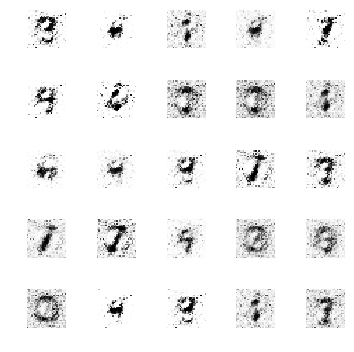


Discriminator evaluation on test set:
256/256 [==============================] - 0s 658us/step

Discriminator metrics on test set -> loss: 0.26 acc: 0.96


--------------- Epoch 20 ---------------


Discriminator metrics on train set -> loss: 0.55 acc: 0.39

Generator images:


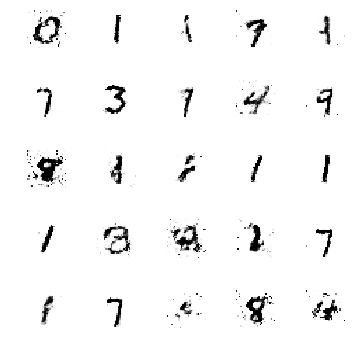


Discriminator evaluation on test set:
256/256 [==============================] - 0s 58us/step

Discriminator metrics on test set -> loss: 0.46 acc: 0.80


--------------- Epoch 40 ---------------


Discriminator metrics on train set -> loss: 0.63 acc: 0.40

Generator images:


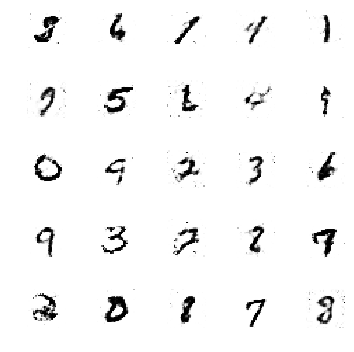


Discriminator evaluation on test set:
256/256 [==============================] - 0s 66us/step

Discriminator metrics on test set -> loss: 0.60 acc: 0.66


--------------- Epoch 60 ---------------


Discriminator metrics on train set -> loss: 0.58 acc: 0.48

Generator images:


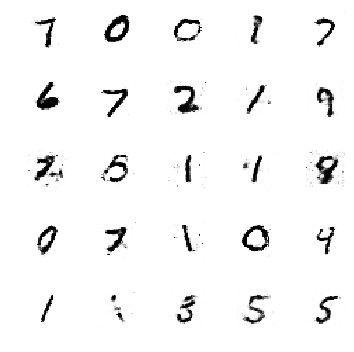


Discriminator evaluation on test set:
256/256 [==============================] - 0s 61us/step

Discriminator metrics on test set -> loss: 0.60 acc: 0.67


--------------- Epoch 80 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.38

Generator images:


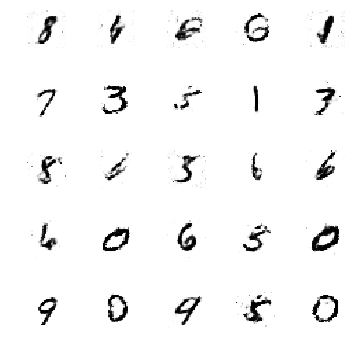


Discriminator evaluation on test set:
256/256 [==============================] - 0s 62us/step

Discriminator metrics on test set -> loss: 0.64 acc: 0.59


--------------- Epoch 100 ---------------


Discriminator metrics on train set -> loss: 0.64 acc: 0.41

Generator images:


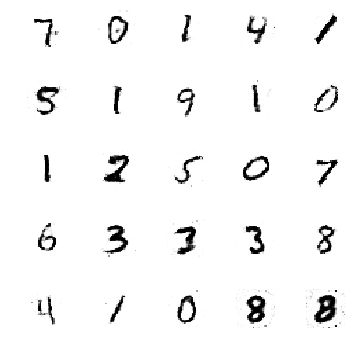


Discriminator evaluation on test set:
256/256 [==============================] - 0s 55us/step

Discriminator metrics on test set -> loss: 0.61 acc: 0.64




In [40]:
# Training for n_epochs and batch_size
n_epochs = 100
batch_size = 128
discriminator, generator, gan, disc_train_history, gan_history, disc_test_history = train(n_epochs, batch_size)

It can be seen that the quality of the generated images improves over time. After a certain number of epochs the results do not seem to change much, although this is a subjective measure. This could mean that the generator is not able to generate more realistic data.

It is possible to plot the evolution of the accuracy of the discriminator with each epoch on both training and test sets. The evolution of generator loss is also plotted.

---Accuracy of discriminator on train set (batch) with number of epochs---


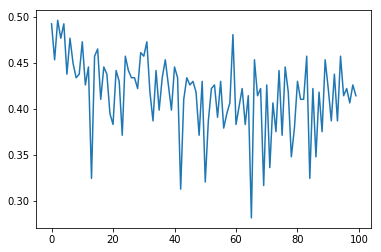

---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---


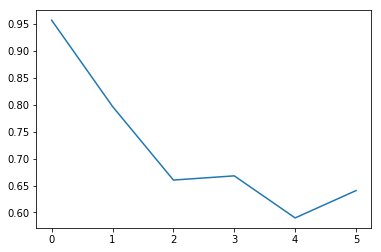

---Loss of generator with number of epochs---


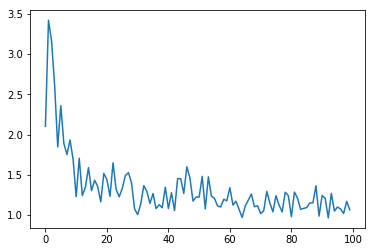

In [54]:
# plot accuracy of discriminator on train set
disc_train_metrics = np.split(np.array(disc_train_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_train_metrics[1])
print("---Accuracy of discriminator on train set (batch) with number of epochs---")
display(fig)
plt.close()

# plot accuracy of discriminator on test set
disc_test_metrics = np.split(np.array(disc_test_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_test_metrics[1])
print("---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---")
display(fig)
plt.close()

# plot evolution of GAN generator loss on train set
gan_metrics = np.split(np.array(gan_history), 2, axis=1)
fig = plt.figure()
plt.plot(gan_metrics[0])
print("---Loss of generator with number of epochs---")
display(fig)
plt.close()

The accuracy of the discriminator on the training set oscillates significantly but it is always kept under 0.5. Ideally the discriminator's output should be:

$$ D(x) = \dfrac{p_{data}(x)}{p_{data}(x) + p_g(x)} $$

Therefore, if the generator gets closer to approximating the real data distribution, the discriminator's output should be close to 0.5.

The accuracy of the discriminator on the test set decreases with training. this may mean that at first the discriminator is able to tell apart real from generated data and gradually becomes less able to distinguish between both. However, the discriminator's accuracy on test data is still higher then 0.5.

Finally, the loss of the generator appears to descend quickly and stays at around the same value for the rest of the training iterations, which could be related to the apparent similar quality of the generated images after a certain number of epochs.

We can save the models architecture and weights in case there is need to use it eventually.

In [59]:
save_model("modelBase", discriminator, generator, gan)

Saved model to disk


## Effect of generator input size ##

Training...

--------------- Epoch 1 ---------------


Discriminator metrics on train set -> loss: 0.37 acc: 0.48

Generator images:


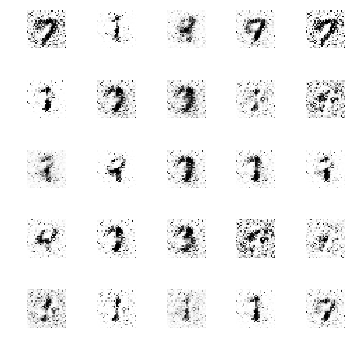


Discriminator evaluation on test set:
256/256 [==============================] - 0s 941us/step

Discriminator metrics on test set -> loss: 0.25 acc: 0.91


--------------- Epoch 20 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.41

Generator images:


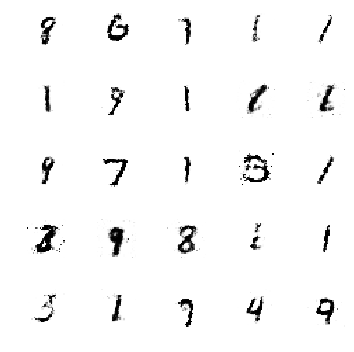


Discriminator evaluation on test set:
256/256 [==============================] - 0s 49us/step

Discriminator metrics on test set -> loss: 0.53 acc: 0.73


--------------- Epoch 40 ---------------


Discriminator metrics on train set -> loss: 0.61 acc: 0.39

Generator images:


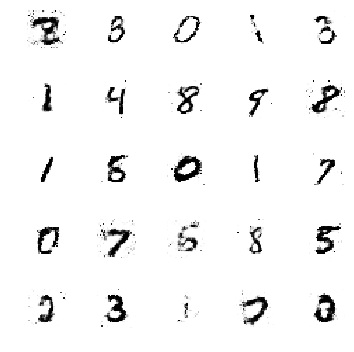


Discriminator evaluation on test set:
256/256 [==============================] - 0s 51us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.65


--------------- Epoch 60 ---------------


Discriminator metrics on train set -> loss: 0.62 acc: 0.44

Generator images:


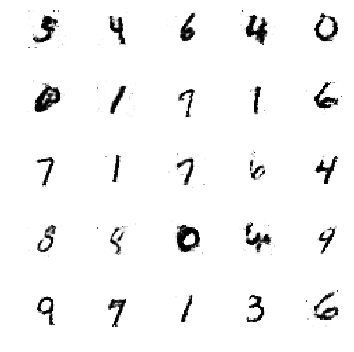


Discriminator evaluation on test set:
256/256 [==============================] - 0s 64us/step

Discriminator metrics on test set -> loss: 0.57 acc: 0.72


--------------- Epoch 80 ---------------


Discriminator metrics on train set -> loss: 0.61 acc: 0.39

Generator images:


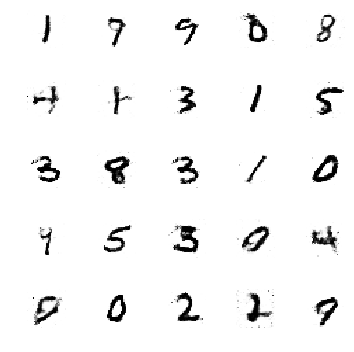


Discriminator evaluation on test set:
256/256 [==============================] - 0s 58us/step

Discriminator metrics on test set -> loss: 0.57 acc: 0.70


--------------- Epoch 100 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.43

Generator images:


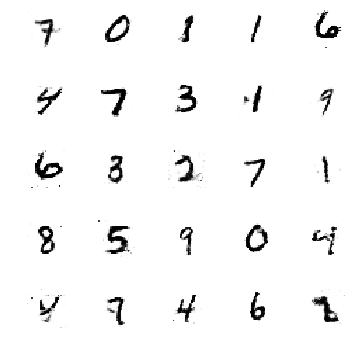


Discriminator evaluation on test set:
256/256 [==============================] - 0s 49us/step

Discriminator metrics on test set -> loss: 0.59 acc: 0.68




In [73]:
# noise vector of 50 elements
n_epochs = 100
batch_size = 128
random_dim = 50
discriminator, generator, gan, disc_train_history, gan_history, disc_test_history = train(n_epochs, batch_size)

---Accuracy of discriminator on train set (batch) with number of epochs---


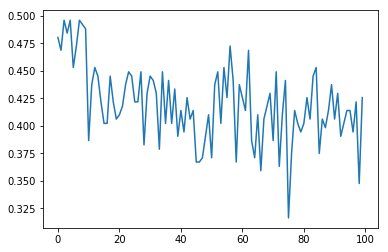

---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---


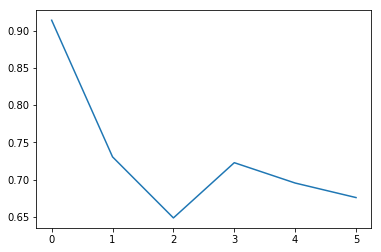

---Loss of generator with number of epochs---


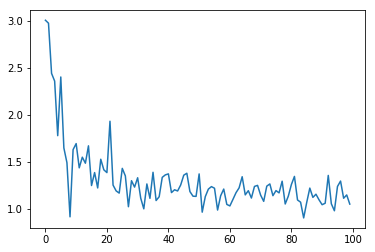

In [74]:
# plot accuracy of discriminator on train set
disc_train_metrics = np.split(np.array(disc_train_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_train_metrics[1])
print("---Accuracy of discriminator on train set (batch) with number of epochs---")
display(fig)
plt.close()

# plot accuracy of discriminator on test set
disc_test_metrics = np.split(np.array(disc_test_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_test_metrics[1])
print("---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---")
display(fig)
plt.close()

# plot evolution of GAN generator loss on train set
gan_metrics = np.split(np.array(gan_history), 2, axis=1)
fig = plt.figure()
plt.plot(gan_metrics[0])
print("---Loss of generator with number of epochs---")
display(fig)
plt.close()

In [76]:
save_model("randomdim50", discriminator, generator, gan)
shutil.copytree("img", os.path.join("randomdim50", "img"))

Saved model to disk


'randomdim50/img'

Training...

--------------- Epoch 1 ---------------


Discriminator metrics on train set -> loss: 0.43 acc: 0.44

Generator images:


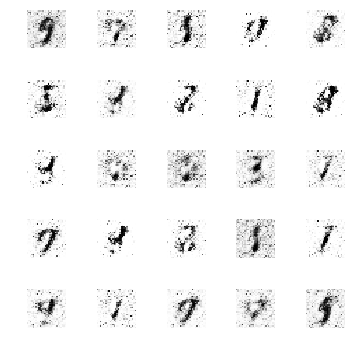


Discriminator evaluation on test set:
256/256 [==============================] - 0s 1ms/step

Discriminator metrics on test set -> loss: 0.45 acc: 0.77


--------------- Epoch 20 ---------------


Discriminator metrics on train set -> loss: 0.50 acc: 0.47

Generator images:


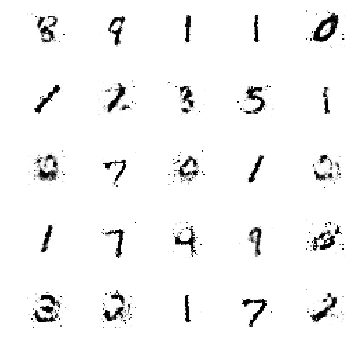


Discriminator evaluation on test set:
256/256 [==============================] - 0s 63us/step

Discriminator metrics on test set -> loss: 0.44 acc: 0.83


--------------- Epoch 40 ---------------


Discriminator metrics on train set -> loss: 0.58 acc: 0.44

Generator images:


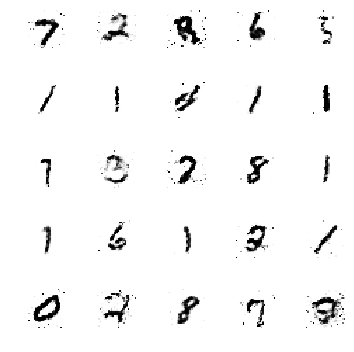


Discriminator evaluation on test set:
256/256 [==============================] - 0s 63us/step

Discriminator metrics on test set -> loss: 0.45 acc: 0.84


--------------- Epoch 60 ---------------


Discriminator metrics on train set -> loss: 0.54 acc: 0.45

Generator images:


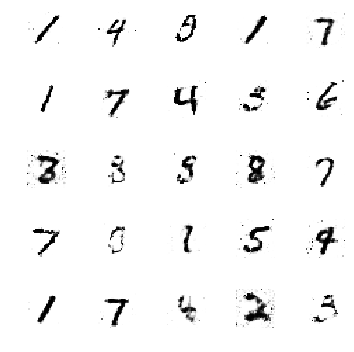


Discriminator evaluation on test set:
256/256 [==============================] - 0s 67us/step

Discriminator metrics on test set -> loss: 0.50 acc: 0.76


--------------- Epoch 80 ---------------


Discriminator metrics on train set -> loss: 0.58 acc: 0.40

Generator images:


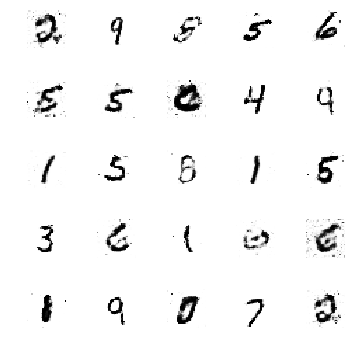


Discriminator evaluation on test set:
256/256 [==============================] - 0s 51us/step

Discriminator metrics on test set -> loss: 0.49 acc: 0.79


--------------- Epoch 100 ---------------


Discriminator metrics on train set -> loss: 0.57 acc: 0.42

Generator images:


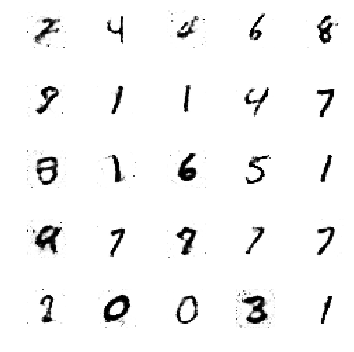


Discriminator evaluation on test set:
256/256 [==============================] - 0s 59us/step

Discriminator metrics on test set -> loss: 0.51 acc: 0.76




In [78]:
# noise vector of 10 elements
random_dim = 10
discriminator, generator, gan, disc_train_history, gan_history, disc_test_history = train(n_epochs, batch_size)

---Accuracy of discriminator on train set (batch) with number of epochs---


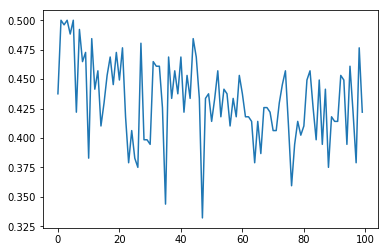

---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---


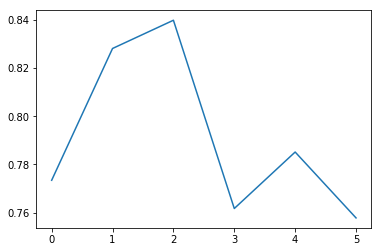

---Loss of generator with number of epochs---


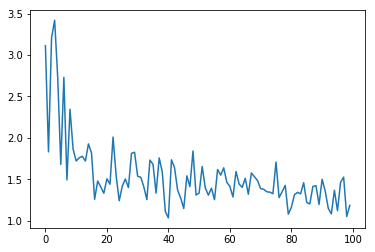

In [79]:
# plot accuracy of discriminator on train set
disc_train_metrics = np.split(np.array(disc_train_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_train_metrics[1])
print("---Accuracy of discriminator on train set (batch) with number of epochs---")
display(fig)
plt.close()

# plot accuracy of discriminator on test set
disc_test_metrics = np.split(np.array(disc_test_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_test_metrics[1])
print("---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---")
display(fig)
plt.close()

# plot evolution of GAN generator loss on train set
gan_metrics = np.split(np.array(gan_history), 2, axis=1)
fig = plt.figure()
plt.plot(gan_metrics[0])
print("---Loss of generator with number of epochs---")
display(fig)
plt.close()

In [80]:
save_model("randomdim10", discriminator, generator, gan)
shutil.copytree("img", os.path.join("randomdim10", "img"))

Saved model to disk


'randomdim10/img'

## Keeping the discriminator near its optimum ##
It is possible, although more costly, to train the discriminator k > 1 times per iteration

Training...

--------------- Epoch 1 ---------------


Discriminator metrics on train set -> loss: 0.30 acc: 0.50

Generator images:


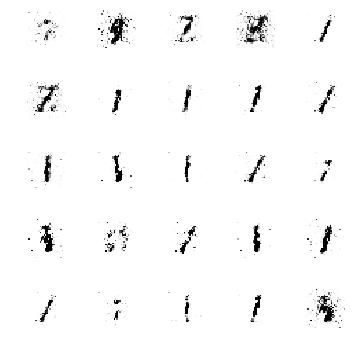


Discriminator evaluation on test set:
256/256 [==============================] - 0s 1ms/step

Discriminator metrics on test set -> loss: 0.21 acc: 0.96


--------------- Epoch 20 ---------------


Discriminator metrics on train set -> loss: 0.47 acc: 0.43

Generator images:


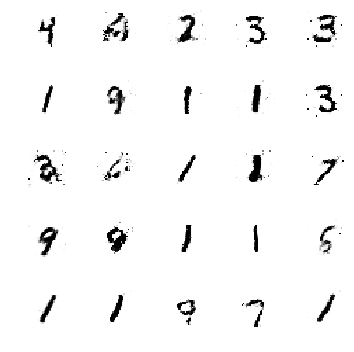


Discriminator evaluation on test set:
256/256 [==============================] - 0s 70us/step

Discriminator metrics on test set -> loss: 0.44 acc: 0.80


--------------- Epoch 40 ---------------


Discriminator metrics on train set -> loss: 0.54 acc: 0.45

Generator images:


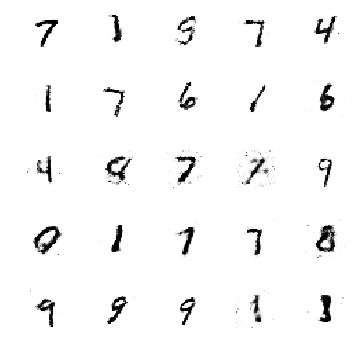


Discriminator evaluation on test set:
256/256 [==============================] - 0s 61us/step

Discriminator metrics on test set -> loss: 0.51 acc: 0.75


--------------- Epoch 60 ---------------


Discriminator metrics on train set -> loss: 0.53 acc: 0.41

Generator images:


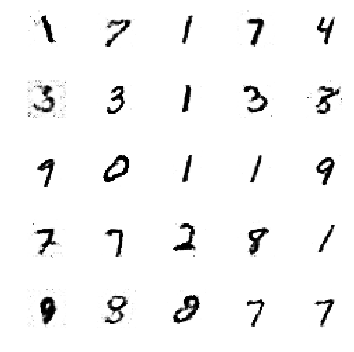


Discriminator evaluation on test set:
256/256 [==============================] - 0s 53us/step

Discriminator metrics on test set -> loss: 0.50 acc: 0.76


--------------- Epoch 80 ---------------


Discriminator metrics on train set -> loss: 0.54 acc: 0.43

Generator images:


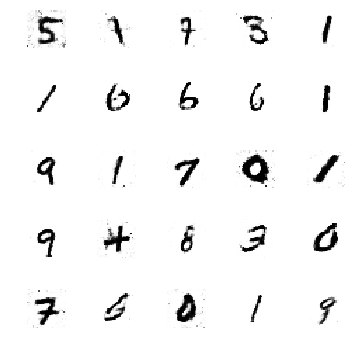


Discriminator evaluation on test set:
256/256 [==============================] - 0s 66us/step

Discriminator metrics on test set -> loss: 0.58 acc: 0.69


--------------- Epoch 100 ---------------


Discriminator metrics on train set -> loss: 0.53 acc: 0.42

Generator images:


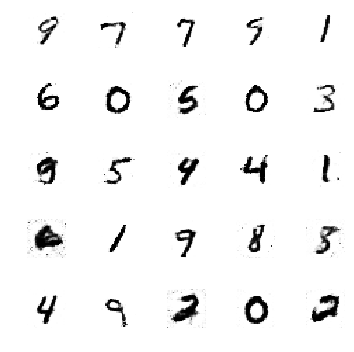


Discriminator evaluation on test set:
256/256 [==============================] - 0s 79us/step

Discriminator metrics on test set -> loss: 0.55 acc: 0.69




In [81]:
# k = 2
n_epochs = 100
batch_size = 128
random_dim = 100
k = 2
discriminator, generator, gan, disc_train_history, gan_history, disc_test_history = train(n_epochs, batch_size, k)

---Accuracy of discriminator on train set (batch) with number of epochs---


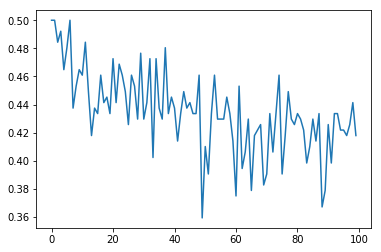

---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---


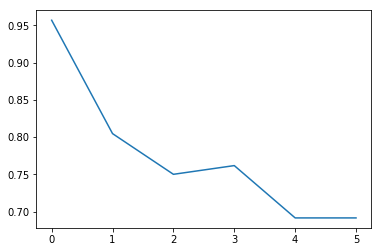

---Loss of generator with number of epochs---


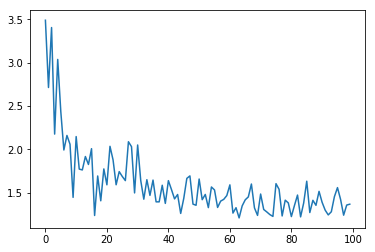

In [82]:
# plot accuracy of discriminator on train set
disc_train_metrics = np.split(np.array(disc_train_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_train_metrics[1])
print("---Accuracy of discriminator on train set (batch) with number of epochs---")
display(fig)
plt.close()

# plot accuracy of discriminator on test set
disc_test_metrics = np.split(np.array(disc_test_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_test_metrics[1])
print("---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---")
display(fig)
plt.close()

# plot evolution of GAN generator loss on train set
gan_metrics = np.split(np.array(gan_history), 2, axis=1)
fig = plt.figure()
plt.plot(gan_metrics[0])
print("---Loss of generator with number of epochs---")
display(fig)
plt.close()

In [83]:
save_model("k2", discriminator, generator, gan)
shutil.copytree("img", os.path.join("k2", "img"))

Saved model to disk


'k2/img'

## Training for more epochs ##

Training...

--------------- Epoch 1 ---------------


Discriminator metrics on train set -> loss: 0.39 acc: 0.49

Generator images:


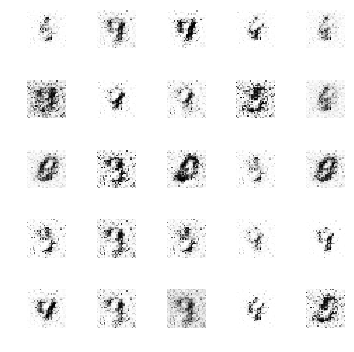


Discriminator evaluation on test set:
256/256 [==============================] - 0s 2ms/step

Discriminator metrics on test set -> loss: 0.34 acc: 0.88


--------------- Epoch 20 ---------------


Discriminator metrics on train set -> loss: 0.56 acc: 0.40

Generator images:


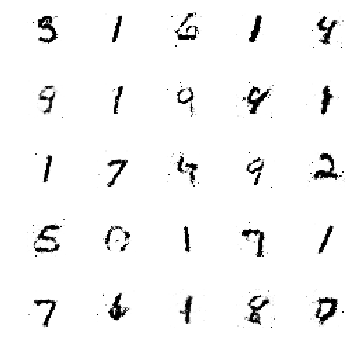


Discriminator evaluation on test set:
256/256 [==============================] - 0s 60us/step

Discriminator metrics on test set -> loss: 0.63 acc: 0.65


--------------- Epoch 40 ---------------


Discriminator metrics on train set -> loss: 0.58 acc: 0.44

Generator images:


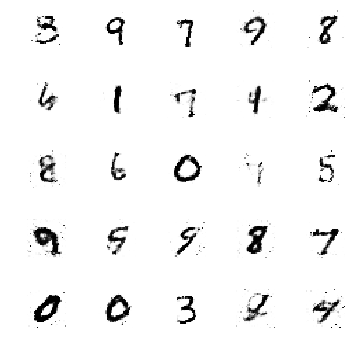


Discriminator evaluation on test set:
256/256 [==============================] - 0s 60us/step

Discriminator metrics on test set -> loss: 0.56 acc: 0.72


--------------- Epoch 60 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.39

Generator images:


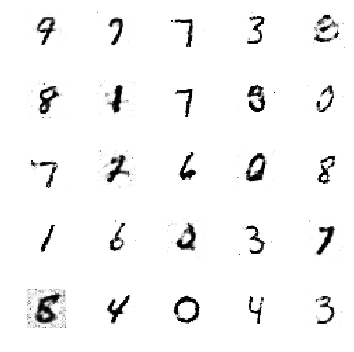


Discriminator evaluation on test set:
256/256 [==============================] - 0s 64us/step

Discriminator metrics on test set -> loss: 0.56 acc: 0.70


--------------- Epoch 80 ---------------


Discriminator metrics on train set -> loss: 0.61 acc: 0.38

Generator images:


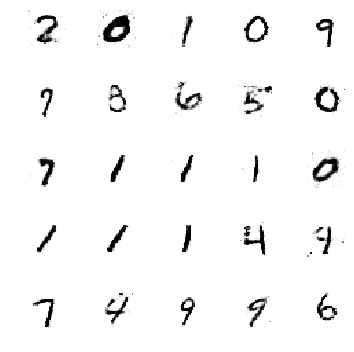


Discriminator evaluation on test set:
256/256 [==============================] - 0s 55us/step

Discriminator metrics on test set -> loss: 0.59 acc: 0.70


--------------- Epoch 100 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.42

Generator images:


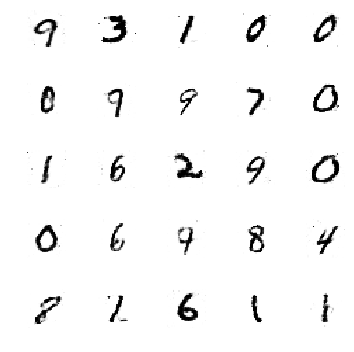


Discriminator evaluation on test set:
256/256 [==============================] - 0s 62us/step

Discriminator metrics on test set -> loss: 0.63 acc: 0.60


--------------- Epoch 120 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.45

Generator images:


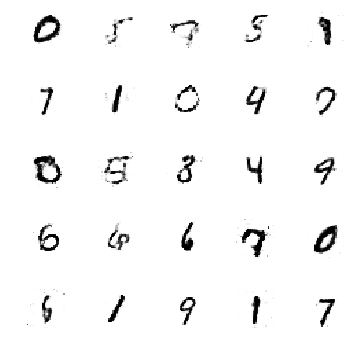


Discriminator evaluation on test set:
256/256 [==============================] - 0s 59us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.66


--------------- Epoch 140 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.41

Generator images:


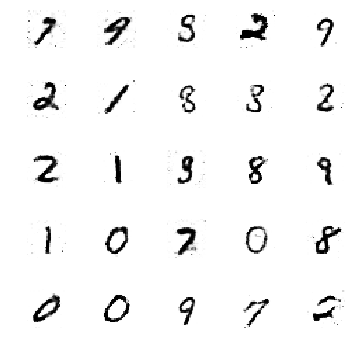


Discriminator evaluation on test set:
256/256 [==============================] - 0s 69us/step

Discriminator metrics on test set -> loss: 0.65 acc: 0.60


--------------- Epoch 160 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.40

Generator images:


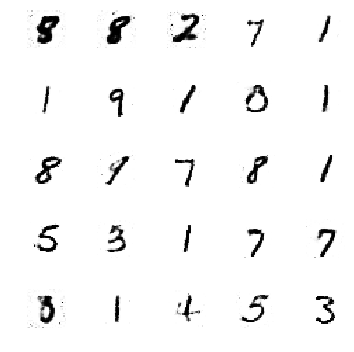


Discriminator evaluation on test set:
256/256 [==============================] - 0s 63us/step

Discriminator metrics on test set -> loss: 0.59 acc: 0.62


--------------- Epoch 180 ---------------


Discriminator metrics on train set -> loss: 0.56 acc: 0.45

Generator images:


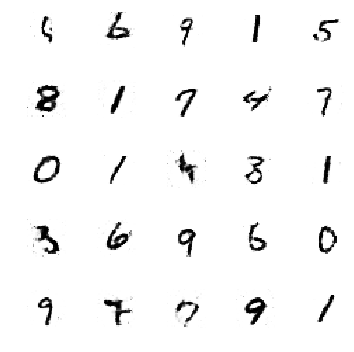


Discriminator evaluation on test set:
256/256 [==============================] - 0s 66us/step

Discriminator metrics on test set -> loss: 0.68 acc: 0.60


--------------- Epoch 200 ---------------


Discriminator metrics on train set -> loss: 0.62 acc: 0.40

Generator images:


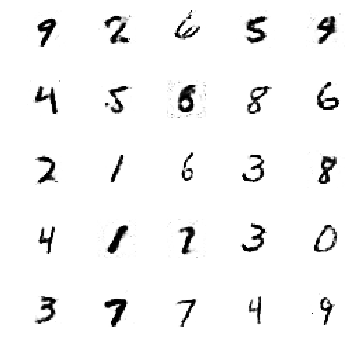


Discriminator evaluation on test set:
256/256 [==============================] - 0s 52us/step

Discriminator metrics on test set -> loss: 0.64 acc: 0.61


--------------- Epoch 220 ---------------


Discriminator metrics on train set -> loss: 0.61 acc: 0.39

Generator images:


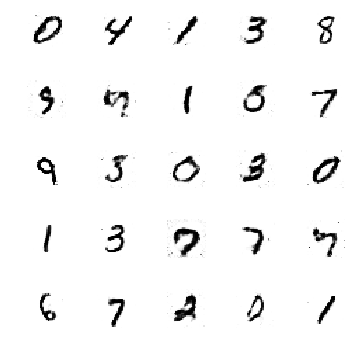


Discriminator evaluation on test set:
256/256 [==============================] - 0s 69us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.59


--------------- Epoch 240 ---------------


Discriminator metrics on train set -> loss: 0.56 acc: 0.45

Generator images:


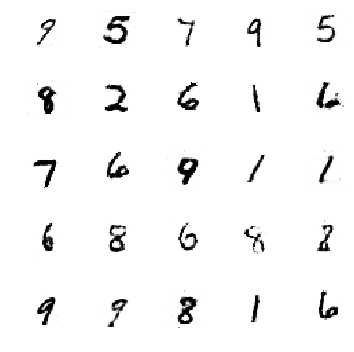


Discriminator evaluation on test set:
256/256 [==============================] - 0s 69us/step

Discriminator metrics on test set -> loss: 0.65 acc: 0.62


--------------- Epoch 260 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.39

Generator images:


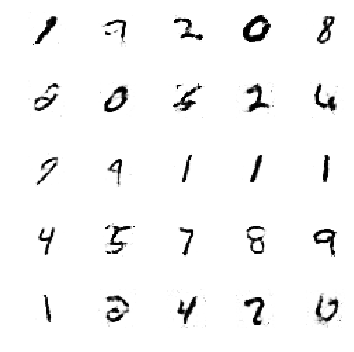


Discriminator evaluation on test set:
256/256 [==============================] - 0s 62us/step

Discriminator metrics on test set -> loss: 0.66 acc: 0.62


--------------- Epoch 280 ---------------


Discriminator metrics on train set -> loss: 0.56 acc: 0.45

Generator images:


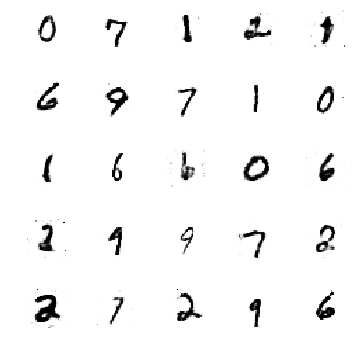


Discriminator evaluation on test set:
256/256 [==============================] - 0s 60us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.63


--------------- Epoch 300 ---------------


Discriminator metrics on train set -> loss: 0.58 acc: 0.42

Generator images:


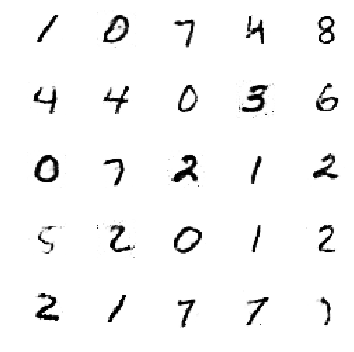


Discriminator evaluation on test set:
256/256 [==============================] - 0s 59us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.64


--------------- Epoch 320 ---------------


Discriminator metrics on train set -> loss: 0.59 acc: 0.44

Generator images:


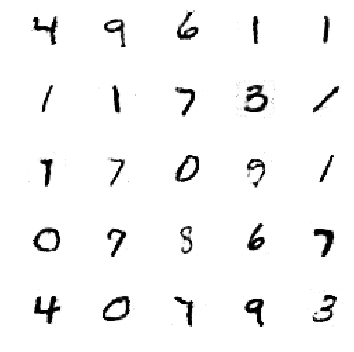


Discriminator evaluation on test set:
256/256 [==============================] - 0s 46us/step

Discriminator metrics on test set -> loss: 0.60 acc: 0.68


--------------- Epoch 340 ---------------


Discriminator metrics on train set -> loss: 0.63 acc: 0.39

Generator images:


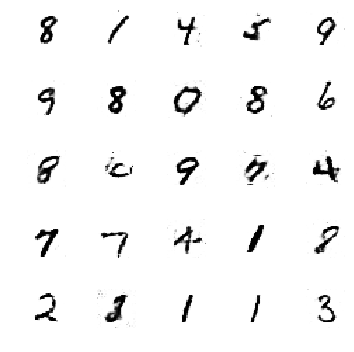


Discriminator evaluation on test set:
256/256 [==============================] - 0s 67us/step

Discriminator metrics on test set -> loss: 0.63 acc: 0.63


--------------- Epoch 360 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.42

Generator images:


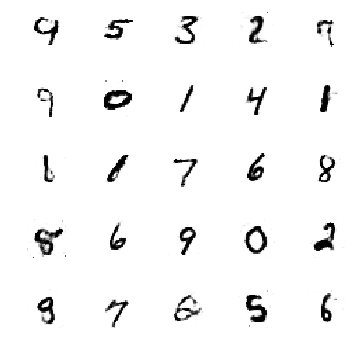


Discriminator evaluation on test set:
256/256 [==============================] - 0s 65us/step

Discriminator metrics on test set -> loss: 0.65 acc: 0.59


--------------- Epoch 380 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.39

Generator images:


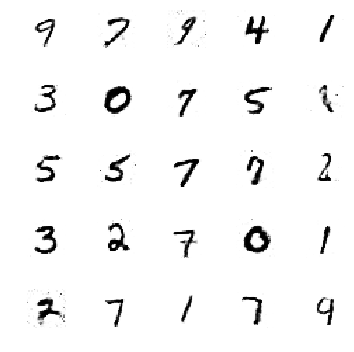


Discriminator evaluation on test set:
256/256 [==============================] - 0s 64us/step

Discriminator metrics on test set -> loss: 0.62 acc: 0.60


--------------- Epoch 400 ---------------


Discriminator metrics on train set -> loss: 0.60 acc: 0.39

Generator images:


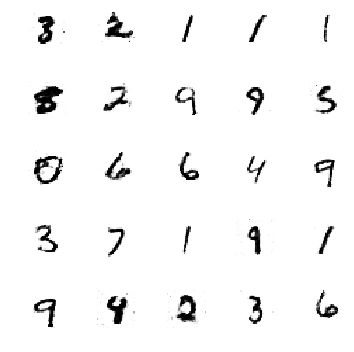


Discriminator evaluation on test set:
256/256 [==============================] - 0s 57us/step

Discriminator metrics on test set -> loss: 0.63 acc: 0.61




In [84]:
# training for 400 epochs
n_epochs = 400
batch_size = 128
random_dim = 100
discriminator, generator, gan, disc_train_history, gan_history, disc_test_history = train(n_epochs, batch_size)

---Accuracy of discriminator on train set (batch) with number of epochs---


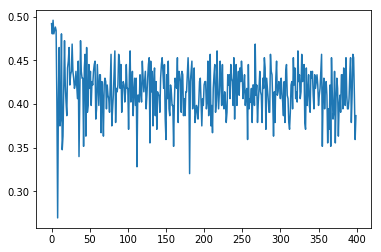

---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---


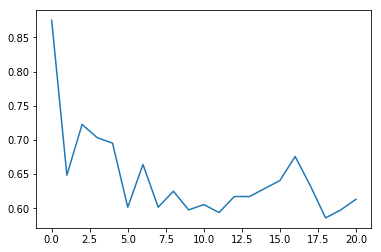

---Loss of generator with number of epochs---


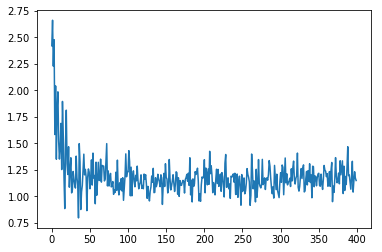

In [85]:
# plot accuracy of discriminator on train set
disc_train_metrics = np.split(np.array(disc_train_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_train_metrics[1])
print("---Accuracy of discriminator on train set (batch) with number of epochs---")
display(fig)
plt.close()

# plot accuracy of discriminator on test set
disc_test_metrics = np.split(np.array(disc_test_history), 2, axis=1)
fig = plt.figure()
plt.plot(disc_test_metrics[1])
print("---Accuracy of discriminator on test set (batch) with number of epochs (only measured every 20 epochs)---")
display(fig)
plt.close()

# plot evolution of GAN generator loss on train set
gan_metrics = np.split(np.array(gan_history), 2, axis=1)
fig = plt.figure()
plt.plot(gan_metrics[0])
print("---Loss of generator with number of epochs---")
display(fig)
plt.close()

In [86]:
save_model("400epochs", discriminator, generator, gan)
shutil.copytree("img", os.path.join("400epochs", "img"))

Saved model to disk


'400epochs/img'